# PhysioNet/CinC 2017 ECG Project (Single Notebook)
This notebook builds an end-to-end ECG rhythm classifier on the **PhysioNet/CinC Challenge 2017** dataset (Normal / AF / Other / Noisy).


Setup

In [ ]:
import os, math, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score



In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Loading labels

In [34]:
labels_df = pd.read_csv('REFERENCE.csv', header=None, names=["record", "label"])

In [35]:
def norm_id(s: str) -> str:
    s = str(s).replace("\\", "/")
    return s.split("/")[-1] 


In [36]:
labels_df["rid"] = labels_df["record"].apply(norm_id)
labels = dict(zip(labels_df["rid"], labels_df["label"]))

In [37]:
from pathlib import Path
mat_root = Path(r"data\training")  
mat_paths = list(mat_root.rglob("*.mat"))



In [38]:
len(mat_paths)

8528

In [39]:
rows = []
for mp in mat_paths:
    rid = mp.stem
    if rid in labels:
        rows.append((rid, str(mp), labels[rid]))

In [40]:
rows

[('A00001', 'data\\training\\A00001.mat', 'N'),
 ('A00002', 'data\\training\\A00002.mat', 'N'),
 ('A00003', 'data\\training\\A00003.mat', 'N'),
 ('A00004', 'data\\training\\A00004.mat', 'A'),
 ('A00005', 'data\\training\\A00005.mat', 'A'),
 ('A00006', 'data\\training\\A00006.mat', 'N'),
 ('A00007', 'data\\training\\A00007.mat', 'N'),
 ('A00008', 'data\\training\\A00008.mat', 'O'),
 ('A00009', 'data\\training\\A00009.mat', 'A'),
 ('A00010', 'data\\training\\A00010.mat', 'N'),
 ('A00011', 'data\\training\\A00011.mat', 'N'),
 ('A00012', 'data\\training\\A00012.mat', 'N'),
 ('A00013', 'data\\training\\A00013.mat', 'O'),
 ('A00014', 'data\\training\\A00014.mat', 'N'),
 ('A00015', 'data\\training\\A00015.mat', 'A'),
 ('A00016', 'data\\training\\A00016.mat', 'N'),
 ('A00017', 'data\\training\\A00017.mat', 'O'),
 ('A00018', 'data\\training\\A00018.mat', 'N'),
 ('A00019', 'data\\training\\A00019.mat', 'N'),
 ('A00020', 'data\\training\\A00020.mat', 'O'),
 ('A00021', 'data\\training\\A00021.mat'

In [41]:
df = pd.DataFrame(rows, columns=["record", "mat_path", "label"])

In [42]:
df

,record,mat_path,label
0,A00001,data\training\A00001.mat,N
1,A00002,data\training\A00002.mat,N
2,A00003,data\training\A00003.mat,N
3,A00004,data\training\A00004.mat,A
4,A00005,data\training\A00005.mat,A
...,...,...,...
8523,A08524,data\training\A08524.mat,N
8524,A08525,data\training\A08525.mat,O
8525,A08526,data\training\A08526.mat,N
8526,A08527,data\training\A08527.mat,N


Loading signals and fixing windowing

In [ ]:
WINDOW_LEN= 300 * 30  

In [44]:
label_map = {"N": 0, "A": 1, "O": 2, "~": 3}
inv_label_map = {v: k for k, v in label_map.items()}
df["y"] = df["label"].map(label_map)

In [45]:
def load_ecg(mat_path: str) -> np.ndarray:
    d = loadmat(mat_path)
    x = d.get("val")
    if x is None:
        keys = [k for k in d.keys() if not k.startswith("__")]
        if len(keys) == 1:
            x = d[keys[0]]
    x = np.asarray(x).squeeze().astype(np.float32)
    return x


In [46]:
def zscore(x: np.ndarray) -> np.ndarray:
    return (x - x.mean()) / (x.std() + 1e-6)


In [47]:
def crop_or_pad(x: np.ndarray, length: int, start: int) -> np.ndarray:
    if len(x) >= length:
        start = max(0, min(start, len(x) - length))
        return x[start:start+length]
    y = np.zeros(length, dtype=np.float32)
    y[:len(x)] = x
    return y

Plotting an Example

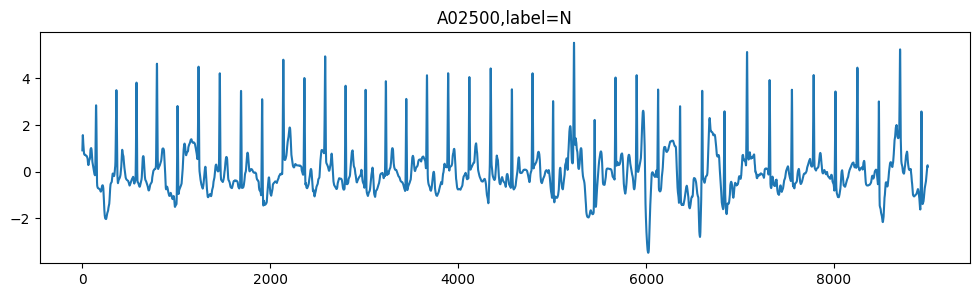

In [49]:
row = df.sample(1, random_state=42).iloc[0]
x = zscore(load_ecg(row["mat_path"]))
start = 0 if len(x) <= WINDOW_LEN else (len(x) - WINDOW_LEN) // 2
w = crop_or_pad(x, WINDOW_LEN, start)

plt.figure(figsize=(12, 3))
plt.plot(w)
plt.title(f"{row['record']},label={row['label']}")
plt.show()


Train/Val/Test Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.15,stratify=df["y"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.15,stratify=train_df["y"], random_state=42)

In [51]:
len(train_df)

6160

In [52]:
len(val_df)

1088

DataLoaders and Augmentation

In [53]:
class ECGDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, train: bool):
        self.frame = frame.reset_index(drop=True)
        self.train = train
    def __len__(self):
        return len(self.frame)
    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        x = zscore(load_ecg(row["mat_path"]))
        if len(x) >= WINDOW_LEN:
            if self.train:
                start = np.random.randint(0, len(x) - WINDOW_LEN + 1)
            else:
                start = (len(x) - WINDOW_LEN) // 2
            x = crop_or_pad(x, WINDOW_LEN, start)
        else:
            x = crop_or_pad(x, WINDOW_LEN, 0)

        xb = torch.from_numpy(x).unsqueeze(0)  
        yb = torch.tensor(int(row["y"]), dtype=torch.long)
        return xb, yb


In [54]:
batch=128

In [55]:
train_loader = DataLoader(ECGDataset(train_df, True), batch_size=batch, shuffle=True, num_workers=0)
val_loader   = DataLoader(ECGDataset(val_df, False), batch_size=batch, shuffle=False, num_workers=0)
test_loader  = DataLoader(ECGDataset(test_df, False), batch_size=batch, shuffle=False, num_workers=0)


Model

In [57]:
device = torch.device("cuda" )

In [60]:
class ResBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, drop=0.0):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1   = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2   = nn.BatchNorm1d(out_ch)
        self.drop  = nn.Dropout(drop) if drop > 0 else nn.Identity()
        self.shortcut = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_ch)
            )

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.drop(h)
        h = self.bn2(self.conv2(h))
        return F.relu(h + self.shortcut(x))

class ResNet1D(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=11, stride=2, padding=5, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.stage1 = nn.Sequential(ResBlock1D(64, 64), ResBlock1D(64, 64))
        self.stage2 = nn.Sequential(ResBlock1D(64, 128, stride=2), ResBlock1D(128, 128))
        self.stage3 = nn.Sequential(ResBlock1D(128, 256, stride=2), ResBlock1D(256, 256, drop=0.1))
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        return self.head(x)





In [61]:
model = ResNet1D(n_classes=4).to(device)

Loss and Optimizer

In [62]:
counts = train_df["y"].value_counts().sort_index().to_numpy()
weights = (counts.sum() / (counts + 1e-6))
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

In [63]:
class_weights

tensor([0.1431, 0.9591, 0.3006, 2.5972], device='cuda:0')

In [64]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-3)

In [65]:
def challenge_score(y_true, y_pred):
    f1s = [f1_score(y_true==c, y_pred==c) for c in [0,1,2]]
    return float(np.mean(f1s)), f1s

Train and Evaluation

In [66]:
@torch.no_grad()
def eval_loader(loader):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy()
        ys.append(yb.numpy())
        ps.append(pred)
    y = np.concatenate(ys)
    p = np.concatenate(ps)
    score, f1s = challenge_score(y, p)
    return score, f1s, y, p

In [67]:
def train_one_epoch(loader):
    model.train()
    total, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total += float(loss.item()) * xb.size(0)
        n += xb.size(0)
    return total / n

In [69]:
ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)
best_path = ART_DIR / "resnet1d_best.pt"

In [70]:
EPOCHS = 15
best_val = -1.0
history = []

In [71]:
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    loss = train_one_epoch(train_loader)
    val_score, val_f1s, _, _ = eval_loader(val_loader)
    dt = time.time() - t0
    history.append((epoch, loss, val_score, *val_f1s))
    print(f"Epoch {epoch:02d} | loss={loss:.4f} | val_score={val_score:.4f} | (N={val_f1s[0]:.3f} A={val_f1s[1]:.3f} O={val_f1s[2]:.3f}) | {dt:.1f}s")

    if val_score > best_val:
        best_val = val_score
        torch.save(model.state_dict(), best_path)
        print("  saved ->", best_path)

hist = pd.DataFrame(history, columns=["epoch","loss","val_score","val_f1_N","val_f1_A","val_f1_O"])
hist


Epoch 01 | loss=1.1595 | val_score=0.3891 | (N=0.751 A=0.410 O=0.006) | 34.8s
  saved -> artifacts\resnet1d_best.pt
Epoch 02 | loss=0.9490 | val_score=0.4318 | (N=0.781 A=0.075 O=0.439) | 25.8s
  saved -> artifacts\resnet1d_best.pt
Epoch 03 | loss=0.8455 | val_score=0.6117 | (N=0.803 A=0.635 O=0.397) | 25.8s
  saved -> artifacts\resnet1d_best.pt
Epoch 04 | loss=0.7790 | val_score=0.4596 | (N=0.400 A=0.532 O=0.447) | 26.8s
Epoch 05 | loss=0.7271 | val_score=0.5350 | (N=0.793 A=0.486 O=0.326) | 26.3s
Epoch 06 | loss=0.7109 | val_score=0.4945 | (N=0.643 A=0.392 O=0.449) | 26.2s
Epoch 07 | loss=0.7124 | val_score=0.5059 | (N=0.795 A=0.620 O=0.104) | 26.1s
Epoch 08 | loss=0.6766 | val_score=0.6223 | (N=0.814 A=0.594 O=0.459) | 27.0s
  saved -> artifacts\resnet1d_best.pt
Epoch 09 | loss=0.6655 | val_score=0.5992 | (N=0.601 A=0.667 O=0.530) | 26.5s
Epoch 10 | loss=0.6725 | val_score=0.5777 | (N=0.832 A=0.326 O=0.575) | 26.8s
Epoch 11 | loss=0.6412 | val_score=0.6119 | (N=0.820 A=0.638 O=0.377

,epoch,loss,val_score,val_f1_N,val_f1_A,val_f1_O
0,1,1.159533,0.389065,0.750693,0.410072,0.006431
1,2,0.949002,0.431786,0.781038,0.075472,0.438849
2,3,0.845468,0.611675,0.802920,0.634783,0.397321
3,4,0.779001,0.459618,0.400485,0.531561,0.446809
4,5,0.727105,0.534998,0.792807,0.486486,0.325700
5,6,0.710901,0.494548,0.642857,0.392157,0.448630
6,7,0.712445,0.505921,0.794538,0.619565,0.103659
7,8,0.676562,0.622283,0.814132,0.594203,0.458515
8,9,0.665528,0.599230,0.600815,0.666667,0.530210
9,10,0.672458,0.577731,0.831913,0.326241,0.575039


In [72]:
best_path = "artifacts/resnet1d_best.pt"
model.load_state_dict(torch.load(best_path, map_location=device))
test_score, test_f1s, y_true, y_pred = eval_loader(test_loader)
print("best checkpoint test challenge score:", test_score)
print("test F1 (N, A, O):", test_f1s)


best checkpoint test challenge score: 0.6661903147809188
test F1 (N, A, O): [0.8406349206349206, 0.6644295302013423, 0.4935064935064935]


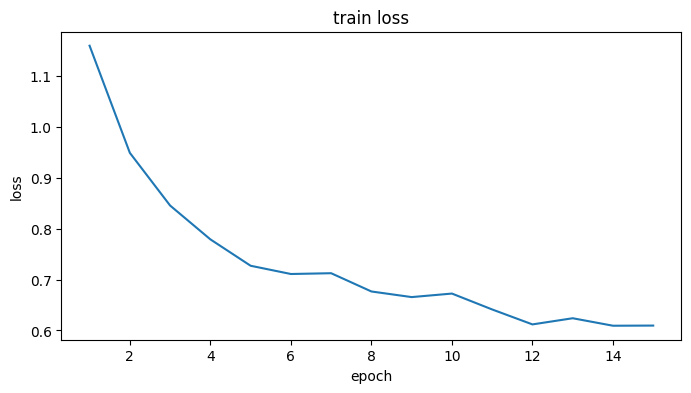

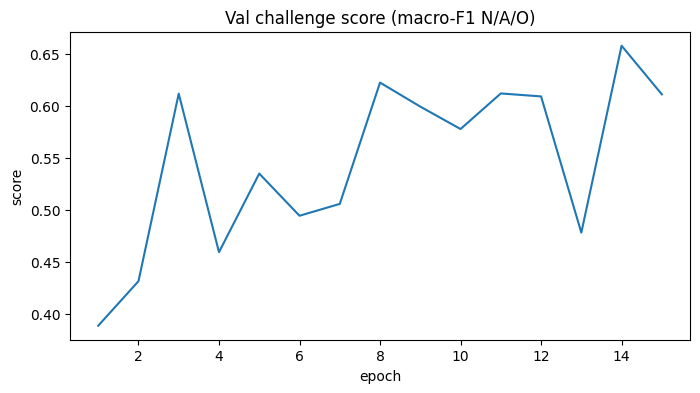

In [73]:
plt.figure(figsize=(8,4))
plt.plot(hist["epoch"], hist["loss"])
plt.title("train loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["epoch"], hist["val_score"])
plt.title("Val challenge score (macro-F1 N/A/O)")
plt.xlabel("epoch"); plt.ylabel("score")
plt.show()


In [74]:

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
print(cm)
o_row = cm[2]
print("True O predicted as [N, A, O, ~]:", o_row)


[[662  21  33  46]
 [  1  99  10   4]
 [147  60 133  22]
 [  3   4   1  34]]
True O predicted as [N, A, O, ~]: [147  60 133  22]


training using 60 as window_sec

In [81]:
WINDOW_LEN = 300 * 60 



In [86]:
run_dir = Path("C:\\Users\\ASUS\\Desktop\\personal\\Projects\\Cinc17\\runs\\resnet_win60")
best_path = run_dir / "best.pt"



In [87]:
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    loss = train_one_epoch(train_loader)
    val_score, val_f1s, _, _ = eval_loader(val_loader)
    dt = time.time() - t0
    history.append((epoch, loss, val_score, *val_f1s))
    print(f"Epoch {epoch:02d} | loss={loss:.4f} | val_score={val_score:.4f} | (N={val_f1s[0]:.3f} A={val_f1s[1]:.3f} O={val_f1s[2]:.3f}) | {dt:.1f}s")

    if val_score > best_val:
        best_val = val_score
        torch.save(model.state_dict(), best_path)
        print("  saved ->", best_path)

hist = pd.DataFrame(history, columns=["epoch","loss","val_score","val_f1_N","val_f1_A","val_f1_O"])
hist


Epoch 01 | loss=0.6539 | val_score=0.6224 | (N=0.750 A=0.577 O=0.541) | 48.1s
Epoch 02 | loss=0.6491 | val_score=0.5944 | (N=0.805 A=0.626 O=0.352) | 48.0s
Epoch 03 | loss=0.6283 | val_score=0.3566 | (N=0.066 A=0.563 O=0.441) | 48.1s
Epoch 04 | loss=0.6237 | val_score=0.6352 | (N=0.751 A=0.614 O=0.540) | 48.4s
Epoch 05 | loss=0.6260 | val_score=0.6774 | (N=0.761 A=0.658 O=0.613) | 48.4s
  saved -> C:\Users\ASUS\Desktop\personal\Projects\Cinc17\runs\resnet_win60\best.pt
Epoch 06 | loss=0.5866 | val_score=0.6655 | (N=0.857 A=0.641 O=0.498) | 51.0s
Epoch 07 | loss=0.5825 | val_score=0.6628 | (N=0.820 A=0.571 O=0.597) | 51.1s
Epoch 08 | loss=0.5826 | val_score=0.3634 | (N=0.033 A=0.625 O=0.432) | 51.0s
Epoch 09 | loss=0.5895 | val_score=0.6745 | (N=0.744 A=0.667 O=0.613) | 50.8s
Epoch 10 | loss=0.6343 | val_score=0.6963 | (N=0.840 A=0.679 O=0.570) | 51.0s
  saved -> C:\Users\ASUS\Desktop\personal\Projects\Cinc17\runs\resnet_win60\best.pt
Epoch 11 | loss=0.5712 | val_score=0.6895 | (N=0.843

,epoch,loss,val_score,val_f1_N,val_f1_A,val_f1_O
0,1,1.159533,0.389065,0.750693,0.410072,0.006431
1,2,0.949002,0.431786,0.781038,0.075472,0.438849
2,3,0.845468,0.611675,0.802920,0.634783,0.397321
3,4,0.779001,0.459618,0.400485,0.531561,0.446809
4,5,0.727105,0.534998,0.792807,0.486486,0.325700
5,6,0.710901,0.494548,0.642857,0.392157,0.448630
6,7,0.712445,0.505921,0.794538,0.619565,0.103659
7,8,0.676562,0.622283,0.814132,0.594203,0.458515
8,9,0.665528,0.599230,0.600815,0.666667,0.530210
9,10,0.672458,0.577731,0.831913,0.326241,0.575039


In [88]:
best_path = r"runs\resnet_win60\best.pt"
model.load_state_dict(torch.load(best_path, map_location=device))
test_score, test_f1s, y_true, y_pred = eval_loader(test_loader)
print("TEST challenge score:", test_score)
print("TEST F1 (N, A, O):", test_f1s)


TEST challenge score: 0.7201694234384068
TEST F1 (N, A, O): [0.8488448844884489, 0.6929133858267716, 0.61875]


In [90]:
results = pd.DataFrame([
    {"run":"win30", "score":0.6661903147809188, "F1_N":0.8406349206349206, "F1_A":0.6644295302013423, "F1_O":0.4935064935064935},
    {"run":"win60", "score":0.7201694234384068, "F1_N":0.8488448844884489, "F1_A":0.6929133858267716, "F1_O":0.61875},
])
results


,run,score,F1_N,F1_A,F1_O
0,win30,0.666190,0.840635,0.664430,0.493506
1,win60,0.720169,0.848845,0.692913,0.618750
